In [1]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

%matplotlib inline

### Функция калибровки весов

Функция принимает на вход вспомогательные признаки $X_i$, $i \in S$, где $S$ -- множество индексов элементов, попавших в выборку, соответствующие признакам значения сумм $T$ по всей генеральной совокупности и набор начальных весов $\{d_i : i \in S\}$. Функция решает задачу оптимизации (4.7)
$$
    \begin{cases}
        \sum\limits_{i \in S} d_i G_\lambda \left( \frac{w_i}{d_i} \right) \rightarrow \min\limits_{\{w_i : i \in S\}},\\
        \sum\limits_{i \in S} w_i X_i = T.
    \end{cases}
$$
и возвращает калиброванные веса $w_i$, $i \in S$. Функция $G_\lambda$ определена в формуле (4.8):
$$
    G_\lambda =
    \begin{cases}
        x\log x - x + 1, \quad \text{если $\lambda = 0$},\\
        \frac{x^{\lambda + 1} - (\lambda + 1)(x - 1) - 1}{\lambda(\lambda + 1)}, \quad \text{если $\lambda > 0$,}
    \end{cases}
$$
где параметр $\lambda \in [0, 1]$ подается на вход функции. Функция описана в Главе 4.2 отчета.

In [2]:
# Метод калибровки весов
#
# initial_weights -- массив формы (n_samples, ); массив начальных весов;
# обычно равен 1 / вероятности_появления
#
# features -- массив формы (n_features x n_samples); массив признаков
#
# totals -- массив формы (n_features, ); суммы признаков по всей генеральной совокупности
#
# power -- неотрицательное число; определяет меру расхождения G_power(x), которую предстоит минимизировать;
# G_power(x) = (x**(power + 1) - (power + 1) * (x - 1) - 1) / power / (power + 1);
# в случаяе power = 0 выражение для G_power(x) стоит понимать как поточечный предел
#
# Значение power = 1 соответствует процедуре GREG, power = 0 -- процедуре raking
#
# tol -- положительное число; значение power приравнивается к 0, если оно по абсолютной величине меньше tol 
#
# Параметры солвера (используется trust-constr):
#   gtol -- положительное число; солвер завершает работу, когда
#   максимальное абсолютное значение компонент градиента Лагранжиана и
#   нарушение ограничений меньше gtol
#
#   xtol -- положительное число; солвер завершает работу, когда радиус шара,
#   на котором функция аппроксимируется модельной, (trust radius) становится меньше xtol
#
#   maxiter -- натуральное число; максимальное число итераций
#
#   verbose -- число из множества {0, 1, 2, 3}, отображает уровень детализации информации о работе солвера
#   verbose = 0 -- информация не выводится
#   verbose = 1 -- выводится отчет о завершении задачи
#   verbose = 2 -- отображается прогресс после каждой итерации
#   verbose = 3 -- наиболее подробный отчет
#
# Возвращаемое значение -- одномерный массив весов, соответствующих элементам выборки
#
def calibrate_weights(initial_weights, features, totals, power=1, tol=1e-3,\
                      gtol=1e-8, xtol=1e-8, maxiter=1000, verbose=0):
    
    # Если power не из отрезка [0, 1], выдать ошибку
    if power < -tol or power > 1 + tol:
        raise ValueError()
    
    # Начальные веса
    d = initial_weights[:]
    # Векторы признаков
    X = features[:, :]
    # Объем выборки
    n = d.shape[0]
    
    D = np.diag(d)
    # Начальное приближение для численного решения задачи оптимизации
    # (является оценкой метода GREG)
    w0 = d + D @ X @ np.linalg.pinv(X.T @ D @ X) @ (totals - X.T @ d)
    
    # Ограничения на взвешенную сумму признаков X.T @ w == totals
    constraint = LinearConstraint(X.T, totals, totals)
    
    # Если power близка к 0, оптимизировать G_0 вместо G_power
    if np.abs(power) < tol:
        # Целевая функция, значение которой предстоить минимизировать
        obj = lambda x : x.T @ np.log(x / d) - np.sum(x)
        # Градиент функции, которую предстоит минимизировать
        grad = lambda x : np.log(x / d)
        # Численное решение задачи оптимизации с помощью scipy
        res = minimize(obj, x0=w0, constraints=constraint, method='trust-constr', jac=grad,\
                       options={'gtol' : gtol, 'xtol' : xtol, 'maxiter' : maxiter, 'verbose' : verbose})
        # Выдать предупреждение, если метод оптимизации не сошелся
        if res.success != 1:
            print('Warning: the optimization method did not converge')
        # Оптимальный набор весов
        w = res.x
    else:
        # Целевая функция, значение которой предстоить минимизировать
        obj = lambda x : d.T @ ((x / d)**(power + 1)) - (power + 1) * np.sum(x)
        # Градиент функции, которую предстоит минимизировать
        grad = lambda x : (power + 1) * ((x / d)**power - 1)
        # Численное решение задачи оптимизации с помощью scipy
        res = minimize(obj, x0=w0, constraints=constraint, method='trust-constr', jac=grad,\
                       options={'gtol' : gtol, 'xtol' : xtol, 'maxiter' : maxiter, 'verbose' : verbose})
        # Выдать предупреждение, если метод оптимизации не сошелся
        if res.success != 1:
            print('Warning: the optimization method did not converge')
        # Оптимальный набор весов
        w = res.x
    
    return w

### Численные эксперименты

Численные эксперименты, описанные в Главе 4.4

### Пример 1: данные займов, калибровка по двум числовым признакам

In [3]:
# Чтение набора данных
data = pd.read_csv('data/Loan_data_with_ID.csv', index_col=0)
print(data.shape)
print(data.head())

(601, 6)
   ID  Gender  Education  ApplicantIncome  LoanAmount  Loan_Status
0   0       0          1           5849.0       127.0            1
1   1       0          1           4583.0       128.0            0
2   2       0          1           3000.0        66.0            1
3   3       0          0           2583.0       120.0            1
4   4       0          1           6000.0       141.0            1


In [4]:
# Выбор признаков для калибровки
feature_columns = ['Education', 'ApplicantIncome']

# Целевая переменная
target_column = 'Loan_Status'

In [5]:
# Подсчет суммарных значений для каждого признака по генеральной совокупности
totals = np.sum(np.array(data[feature_columns]), axis=0)
print(totals)

[4.680000e+02 3.183388e+06]


In [6]:
# Объем генеральной совокупности
n_total = data.shape[0]

# Объем выборки (не более n_total)
n_sample = 150

# Начальные веса
initial_weights = n_total / n_sample * np.ones(n_sample)

In [7]:
np.random.seed(13)

# Генерирование выборки
sample = np.random.choice(data['ID'], size=n_sample, replace=False)
# Вывод ID клиентов, попавших в выборку 
print(sample)

[563 226 486 293 137  45 152 265  40 382 601 523 159 127 593 539 604 533
  94  30 146 422 359 589 352 405 602  70 239 308 603 149 191 494 529 180
 138 561 163 358   0 353 298 290 238 311   3 100 186 325 594 566 491 253
 473  66  99 557 500  34 245 412 153 102 581 434 230  86 570 315 372 472
 584 537 504  59  31 476 267 108 200   7 201 376 241 119 246 587 468 545
 326  77 182 135 218 559 199 256 109 436 280 392 196 173  72 264 443 530
 193 562 408 321 107 291 520 161 115 606 272 396 354  53 285 269 389 528
 573 114 244 463  28 451 157 158 296 553 373 574 548 106  35 120 197  68
 469 346 447  36 431 144]


In [8]:
# Составление массива признаков и массива целевой переменной

features = np.empty((0, len(feature_columns)))
y = []

for s in sample:
    
    s_features = data[data['ID'] == s][feature_columns]
    features = np.append(features, np.array(s_features).reshape(1, -1), axis=0)
    
    y += [data[data['ID'] == s][target_column]]

y = np.array(y).reshape(-1)

In [9]:
# Вычисление калиброванных оценок при различных значениях степени

power_list = np.linspace(0, 1, 21)

estimates = []

for p in power_list:
    w = calibrate_weights(initial_weights, features, totals, power=p)
    estimates += [w.T @ y]

Наилучшее значение показателя: 1.0


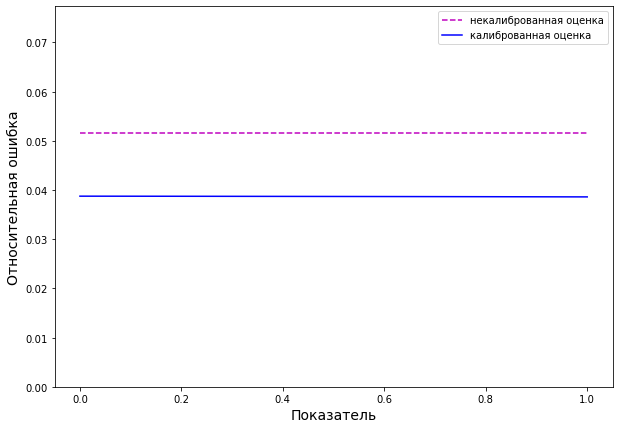

In [10]:
# Настоящее значение суммы целевой переменной по всей генеральной совокупности
y_total = data[target_column].sum()

# Стандартная (некалиброванная) оценка суммы генеральной совокупности с одинаковыми весами
y_sample = np.sum(y)
y_naive = n_total / n_sample * y_sample

# Подсчет величины ошибки и поиск оптимального значения степени

# Относительная ошибка стандартной оценки
error_naive = np.abs(y_naive - y_total) / y_total

# Относительные ошибки калиброванных оценок
errors = np.abs(estimates - y_total) / y_total

power_best = power_list[np.argmin(errors)]
print('Наилучшее значение показателя:', power_best)

plt.figure(figsize=(10, 7))
plt.plot(power_list, error_naive * np.ones(len(power_list)), 'm--', label='некалиброванная оценка')
plt.plot(power_list, errors, 'b-', label='калиброванная оценка')
plt.xlabel('Показатель', fontsize=14)
plt.ylabel('Относительная ошибка', fontsize=14)
plt.ylim(0, np.maximum(np.max(errors), error_naive) * 1.5)
plt.legend(loc=0)
plt.savefig('images/calibration_loan_data.png')
plt.show()

In [11]:
# Настоящее значение суммы целевой переменной по всей генеральной совокупности
y_total = data[target_column].sum()
print('Сумма генеральной совокупности:', y_total)

# Стандартная оценка суммы генеральной совокупности с одинаковыми весами
y_sample = np.sum(y)
y_naive = n_total / n_sample * y_sample
print('Стандартная (некалиброванная) оценка:', y_naive)

# Калибровка методом GREG
w = calibrate_weights(initial_weights, features, totals, power=1, verbose=1)
print('GREG:', w.T @ y)

# Калибровка методом raking
w = calibrate_weights(initial_weights, features, totals, power=0, verbose=1)
print('Raking:', w.T @ y)

# Калибровка с наилучшим показателем
w = calibrate_weights(initial_weights, features, totals, power=power_best, verbose=1)
print('Калибровка с показателем', power_best, ':', w.T @ y)

Сумма генеральной совокупности: 414
Стандартная (некалиброванная) оценка: 392.65333333333336
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 4.16e-16, constraint violation: 4.66e-10, execution time: 0.00066 s.
GREG: 398.02010569980985
`xtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 29, CG iterations: 17, optimality: 2.53e-08, constraint violation: 0.00e+00, execution time: 0.016 s.
Raking: 397.9586815097107
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 4.16e-16, constraint violation: 4.66e-10, execution time: 0.00035 s.
Калибровка с показателем 1.0 : 398.02010569980985


### Пример 2: данные займов, калибровка по количеству наблюдений в стратах

Калибровка по количеству наблюдений в стратах описана в Главе 4.3 отчета

In [12]:
# Страты, полученные с помощью алгоритма, переданного индустриальным партнером
sber_strata = joblib.load('saved_variables/Sber_data_stratification_loan.joblib')
print(sber_strata.keys())

# Объединения страт, полученные в результате применения генетического алгоритма
ga_strata_unions = joblib.load('saved_variables/GA_data_stratification_loan.joblib')
print(ga_strata_unions)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
[[5, 11, 12], [0, 3], [], [1], [6], [8, 16], [9, 15], [2], [], [7, 10], [], [14], [], [], [], [], [4, 13], [17]]


In [13]:
# Чтение набора данных
data = pd.read_csv('data/Loan_data_with_ID.csv', index_col=0)
print(data.shape)
print(data.head())

# Целевая переменная
target_column = 'Loan_Status'

(601, 6)
   ID  Gender  Education  ApplicantIncome  LoanAmount  Loan_Status
0   0       0          1           5849.0       127.0            1
1   1       0          1           4583.0       128.0            0
2   2       0          1           3000.0        66.0            1
3   3       0          0           2583.0       120.0            1
4   4       0          1           6000.0       141.0            1


In [14]:
# Объем генеральной совокупности
n_total = data.shape[0]

# Объем выборки (не более n_total)
n_sample = 150

# Начальные веса
initial_weights = n_total / n_sample * np.ones(n_sample)

In [15]:
np.random.seed(13)

# Генерирование выборки
sample = np.random.choice(data['ID'], size=n_sample, replace=False)
# Вывод ID клиентов, попавших в выборку 
print(sample)

[563 226 486 293 137  45 152 265  40 382 601 523 159 127 593 539 604 533
  94  30 146 422 359 589 352 405 602  70 239 308 603 149 191 494 529 180
 138 561 163 358   0 353 298 290 238 311   3 100 186 325 594 566 491 253
 473  66  99 557 500  34 245 412 153 102 581 434 230  86 570 315 372 472
 584 537 504  59  31 476 267 108 200   7 201 376 241 119 246 587 468 545
 326  77 182 135 218 559 199 256 109 436 280 392 196 173  72 264 443 530
 193 562 408 321 107 291 520 161 115 606 272 396 354  53 285 269 389 528
 573 114 244 463  28 451 157 158 296 553 373 574 548 106  35 120 197  68
 469 346 447  36 431 144]


#### Пример с разбиением на страты, полученных с помощью алгоритма индустриального партнера

In [16]:
# Подсчет количества элементов в каждой страте
totals = [len(sber_strata[k]) for k in sber_strata.keys()]
    
totals = np.array(totals)
print(totals)

[  1   7   2   2  21  32   4  15  49  20  16  15  20  88  78  13  83 135]


In [17]:
# Составление массива признаков и массива целевой переменной

features = np.empty((0, len(sber_strata.keys())))
y = []

for s in sample:
    
    s_features = [int(s in sber_strata[k]) for k in sber_strata.keys()]
    features = np.append(features, np.array(s_features).reshape(1, -1), axis=0)
    
    y += [data[data['ID'] == s][target_column]]

y = np.array(y).reshape(-1)

In [18]:
# Провести калибровку только по стратам, размер которых больше n_min
n_min = 50
features = features.T[totals > n_min].T
totals = totals[totals > n_min]

print(features.shape, totals.shape)

(150, 4) (4,)


In [19]:
# Вычисление калиброванных оценок при различных значениях степени

power_list = np.linspace(0, 1, 21)

estimates = []

for p in power_list:
    w = calibrate_weights(initial_weights, features, totals, power=p)
    estimates += [w.T @ y]

Наилучшее значение показателя: 0.0


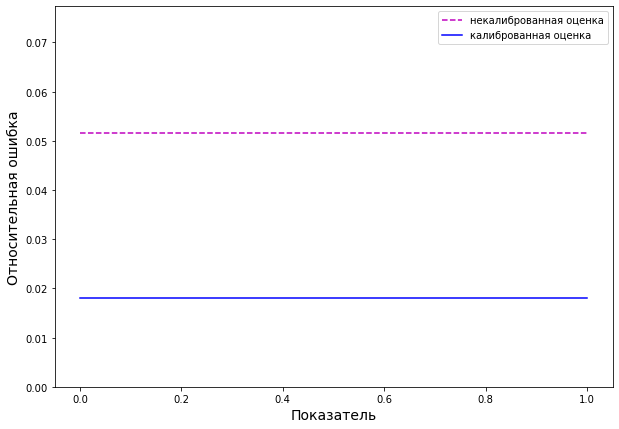

In [20]:
# Настоящее значение суммы целевой переменной по всей генеральной совокупности
y_total = data[target_column].sum()

# Стандартная (некалиброванная) оценка суммы генеральной совокупности с одинаковыми весами
y_sample = np.sum(y)
y_naive = n_total / n_sample * y_sample

# Подсчет величины ошибки и поиск оптимального значения степени

# Относительная ошибка стандартной оценки
error_naive = np.abs(y_naive - y_total) / y_total

# Относительные ошибки калиброванных оценок
errors = np.abs(estimates - y_total) / y_total

power_best = power_list[np.argmin(errors)]
print('Наилучшее значение показателя:', power_best)

plt.figure(figsize=(10, 7))
plt.plot(power_list, error_naive * np.ones(len(power_list)), 'm--', label='некалиброванная оценка')
plt.plot(power_list, errors, 'b-', label='калиброванная оценка')
plt.xlabel('Показатель', fontsize=14)
plt.ylabel('Относительная ошибка', fontsize=14)
plt.ylim(0, np.maximum(np.max(errors), error_naive) * 1.5)
plt.legend(loc=0)
plt.savefig('images/calmar_loan_data.png')
plt.show()

In [21]:
# Настоящее значение суммы целевой переменной по всей генеральной совокупности
y_total = data[target_column].sum()
print('Сумма генеральной совокупности:', y_total)

# Стандартная оценка суммы генеральной совокупности с одинаковыми весами
y_sample = np.sum(y)
y_naive = n_total / n_sample * y_sample
print('Стандартная (некалиброванная) оценка:', y_naive)

# Калибровка методом GREG
w = calibrate_weights(initial_weights, features, totals, power=1, verbose=1)
print('GREG:', w.T @ y)

# Калибровка методом raking
w = calibrate_weights(initial_weights, features, totals, power=0, verbose=1)
print('Raking:', w.T @ y)

# Калибровка с наилучшим показателем
w = calibrate_weights(initial_weights, features, totals, power=power_best, verbose=1)
print('Калибровка с показателем', power_best, ':', w.T @ y)

Сумма генеральной совокупности: 414
Стандартная (некалиброванная) оценка: 392.65333333333336
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 0.00e+00, constraint violation: 2.84e-14, execution time: 0.00052 s.
GREG: 406.5111447991174
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 5.55e-17, constraint violation: 2.84e-14, execution time: 0.00032 s.
Raking: 406.5111447991174
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 5.55e-17, constraint violation: 2.84e-14, execution time: 0.0003 s.
Калибровка с показателем 0.0 : 406.5111447991174


#### Пример с разбиением на страты, полученных с помощью генетического алгоритма

In [22]:
# Страты, полученные с помощью генетического алгоритма
ga_strata = dict()

key = 0

for union in ga_strata_unions:
    
    if len(union) == 0:
        continue
    
    ga_strata[key] = []
    
    for k in union:
        ga_strata[key] += sber_strata[k]
        
    key += 1

In [23]:
# Подсчет количества элементов в каждой страте
totals = [len(ga_strata[k]) for k in ga_strata.keys()]
    
totals = np.array(totals)
print(totals)

[ 67   3   7   4 132  33   2  31  78 109 135]


In [24]:
# Составление массива признаков и массива целевой переменной

features = np.empty((0, len(ga_strata.keys())))
y = []

for s in sample:
    
    s_features = [int(s in ga_strata[k]) for k in ga_strata.keys()]
    features = np.append(features, np.array(s_features).reshape(1, -1), axis=0)
    
    y += [data[data['ID'] == s][target_column]]

y = np.array(y).reshape(-1)

In [25]:
# Провести калибровку только по стратам, размер которых больше n_min
n_min = 70
features = features.T[totals > n_min].T
totals = totals[totals > n_min]

print(features.shape, totals.shape)

(150, 4) (4,)


In [26]:
# Вычисление калиброванных оценок при различных значениях степени

power_list = np.linspace(0, 1, 21)

estimates = []

for p in power_list:
    w = calibrate_weights(initial_weights, features, totals, power=p)
    estimates += [w.T @ y]

Наилучшее значение показателя: 0.0


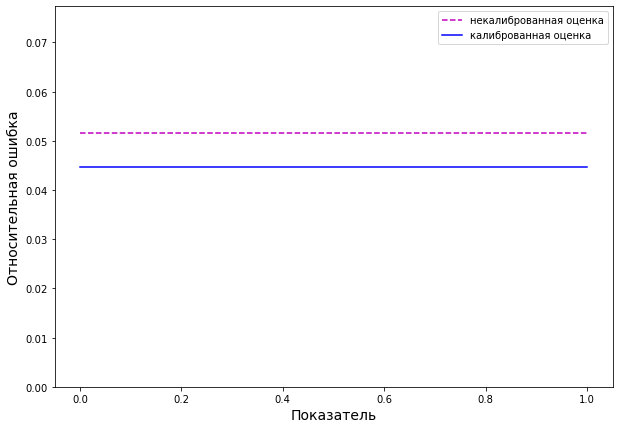

In [27]:
# Настоящее значение суммы целевой переменной по всей генеральной совокупности
y_total = data[target_column].sum()

# Стандартная (некалиброванная) оценка суммы генеральной совокупности с одинаковыми весами
y_sample = np.sum(y)
y_naive = n_total / n_sample * y_sample

# Подсчет величины ошибки и поиск оптимального значения степени

# Относительная ошибка стандартной оценки
error_naive = np.abs(y_naive - y_total) / y_total

# Относительные ошибки калиброванных оценок
errors = np.abs(estimates - y_total) / y_total

power_best = power_list[np.argmin(errors)]
print('Наилучшее значение показателя:', power_best)

# Строим зависимость относительной ошибки предсказания от значения параметра, использованного при калибровке
plt.figure(figsize=(10, 7))
plt.plot(power_list, error_naive * np.ones(len(power_list)), 'm--', label='некалиброванная оценка')
plt.plot(power_list, errors, 'b-', label='калиброванная оценка')
plt.xlabel('Показатель', fontsize=14)
plt.ylabel('Относительная ошибка', fontsize=14)
plt.ylim(0, np.maximum(np.max(errors), error_naive) * 1.5)
plt.legend(loc=0)
plt.savefig('images/calmar_loan_data_genetic.png')
plt.show()

In [28]:
# Настоящее значение суммы целевой переменной по всей генеральной совокупности
y_total = data[target_column].sum()
print('Сумма генеральной совокупности:', y_total)

# Стандартная оценка суммы генеральной совокупности с одинаковыми весами
y_sample = np.sum(y)
y_naive = n_total / n_sample * y_sample
print('Стандартная (некалиброванная) оценка:', y_naive)

# Калибровка методом GREG
w = calibrate_weights(initial_weights, features, totals, power=1, verbose=1)
print('GREG:', w.T @ y)

# Калибровка методом raking
w = calibrate_weights(initial_weights, features, totals, power=0, verbose=1)
print('Raking:', w.T @ y)

# Калибровка с наилучшим показателем
w = calibrate_weights(initial_weights, features, totals, power=power_best, verbose=1)
print('Калибровка с показателем', power_best, ':', w.T @ y)

Сумма генеральной совокупности: 414
Стандартная (некалиброванная) оценка: 392.65333333333336
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 5.55e-17, constraint violation: 2.84e-14, execution time: 0.00057 s.
GREG: 395.46608214247595
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 2.78e-17, constraint violation: 2.84e-14, execution time: 0.00029 s.
Raking: 395.46608214247595
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 2.78e-17, constraint violation: 2.84e-14, execution time: 0.00027 s.
Калибровка с показателем 0.0 : 395.46608214247595


### Пример 3: искусственные данные с количественной целевой переменной с распределением Пуассона (стр. 40 отчета)

In [29]:
# Генерирование синтетических данных с двумя признаками с нормальным распределением
# и с целевой переменной с распределением Пуассона
np.random.seed(1)

# Размер генеральной совокупности
n_population = 1000

# Генерирование ковариационной матрицы признаков
eigenvalues = 2 * np.random.rand(2)
eigenvectors, _, _ = np.linalg.svd(np.random.rand(2, 2))
cov = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
print('Ковариационная матрица признаков:')
print(cov)
# Квадратный корень из ковариационной матрицы
cov_sqrt = eigenvectors @ np.diag(eigenvalues**0.5) @ eigenvectors.T

# Генерирование признаков
features = np.random.randn(1000, 2) @ cov_sqrt
print(features.shape)

# Генерирование целевой переменной
v = np.random.rand(2)
print('v =', v)
target = np.random.poisson(np.exp(features @ v))

Ковариационная матрица признаков:
[[ 0.91310778 -0.20422878]
 [-0.20422878  1.36158522]]
(1000, 2)
v = [0.15073966 0.24376398]


In [30]:
# Подсчет суммарных значений для каждого признака по генеральной совокупности
totals = np.sum(features, axis=0)
print(totals)

[33.81829137 28.25579226]


In [31]:
# Объем выборки (не более n_population)
n_sample = 100

# Начальные веса
initial_weights = n_population / n_sample * np.ones(n_sample)

In [32]:
np.random.seed(13)

# Генерирование выборки
sample = np.random.choice(np.arange(n_population), size=n_sample, replace=False)
# Вывод индексов, попавших в выборку 
print(sample)

# Признаки и целевые переменные элементов выборки 
X = features[sample]
y = target[sample]

[945 452 304 433 864 291 986 923 260 546 591 390 407 261 594 618 196  78
 765 644 991 417 416 165 279 388 576 810 729 669 785 674 987 480 612 362
 855  70 779 675 545 337 736 740 687 380 414 346 570 189 751 593 743 663
 108 878 542 192 371 561 972 336 670 872 553 624 647 577 472 114  63  15
 275 423 458 822 928 830 828 512 222 195 459 799 363 980 705  98 733  46
 731 411 721  58 877 430 677  99 918 921]


In [33]:
# Вычисление калиброванных оценок при различных значениях степени

power_list = np.linspace(0, 1, 21)

estimates = []

for p in power_list:
    w = calibrate_weights(initial_weights, X, totals, power=p)
    estimates += [w.T @ y]

Наилучшее значение показателя: 1.0


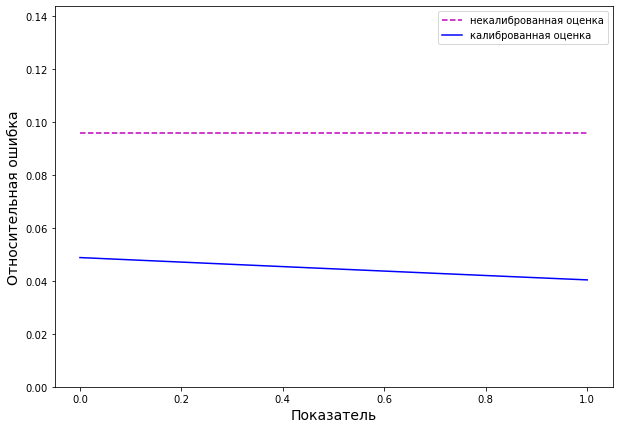

In [34]:
# Настоящее значение суммы целевой переменной по всей генеральной совокупности
y_total = target.sum()

# Стандартная (некалиброванная) оценка суммы генеральной совокупности с одинаковыми весами
y_sample = np.sum(y)
y_naive = n_population / n_sample * y_sample

# Подсчет величины ошибки и поиск оптимального значения степени

# Относительная ошибка стандартной оценки
error_naive = np.abs(y_naive - y_total) / y_total

# Относительные ошибки калиброванных оценок
errors = np.abs(estimates - y_total) / y_total

power_best = power_list[np.argmin(errors)]
print('Наилучшее значение показателя:', power_best)

# Строим зависимость относительной ошибки предсказания от значения параметра, использованного при калибровке
plt.figure(figsize=(10, 7))
plt.plot(power_list, error_naive * np.ones(len(power_list)), 'm--', label='некалиброванная оценка')
plt.plot(power_list, errors, 'b-', label='калиброванная оценка')
plt.xlabel('Показатель', fontsize=14)
plt.ylabel('Относительная ошибка', fontsize=14)
plt.ylim(0, np.maximum(np.max(errors), error_naive) * 1.5)
plt.legend(loc=0)
plt.savefig('images/calibration_synthetic_data.png')
plt.show()

In [35]:
# Настоящее значение суммы целевой переменной по всей генеральной совокупности
y_total = target.sum()
print('Сумма генеральной совокупности:', y_total)

# Стандартная оценка суммы генеральной совокупности с одинаковыми весами
y_sample = np.sum(y)
y_naive = n_population / n_sample * y_sample
print('Стандартная (некалиброванная) оценка:', y_naive)

# Калибровка методом GREG
w = calibrate_weights(initial_weights, X, totals, power=1, verbose=1)
print('GREG:', w.T @ y)

# Калибровка методом raking
w = calibrate_weights(initial_weights, X, totals, power=0, verbose=1)
print('Raking:', w.T @ y)

# Калибровка с наилучшим показателем
w = calibrate_weights(initial_weights, X, totals, power=power_best, verbose=1)
print('Калибровка с показателем', power_best, ':', w.T @ y)

Сумма генеральной совокупности: 1013
Стандартная (некалиброванная) оценка: 1110.0
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 3.61e-16, constraint violation: 6.75e-14, execution time: 0.00036 s.
GREG: 1053.8790268093085
`gtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 15, CG iterations: 14, optimality: 1.91e-09, constraint violation: 2.84e-14, execution time: 0.012 s.
Raking: 1062.4157177368988
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 3.61e-16, constraint violation: 6.75e-14, execution time: 0.00022 s.
Калибровка с показателем 1.0 : 1053.8790268093085
